# `CountVectorizer` and `MultinomialNB` Model

# Imports libraries

In [1]:
import re
import nltk
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag

In [2]:
plt.style.use('dark_background')

# Read in both .csv data

In [3]:
weird = pd.read_csv('./data/weird.csv')
weird.head()

In [4]:
stupid = pd.read_csv('./data/stupid.csv')
stupid.head()

# Append and check data

In [7]:
df = weird.append(stupid)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 999
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     2000 non-null   int64  
 1   all_awardings                  2000 non-null   object 
 2   allow_live_comments            2000 non-null   bool   
 3   author                         2000 non-null   object 
 4   author_flair_css_class         0 non-null      float64
 5   author_flair_richtext          1990 non-null   object 
 6   author_flair_text              0 non-null      float64
 7   author_flair_type              1990 non-null   object 
 8   author_fullname                1990 non-null   object 
 9   author_patreon_flair           1990 non-null   object 
 10  author_premium                 1990 non-null   object 
 11  awarders                       2000 non-null   object 
 12  can_mod_post                   2000 non-null   bo

In [8]:
df.shape

(2000, 72)

# Reindex columns

In [9]:
df.set_index(df['subreddit'])

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,...,whitelist_status,wls,media,media_embed,secure_media,secure_media_embed,author_flair_background_color,author_flair_text_color,Unnamed: 68,Unnamed: 69
subreddit,,,,,,,,,,,,,,,,,,,,,
NewsOfTheWeird,0,[],False,MaryRUy,NaN,[],NaN,text,t2_9ccpwdcv,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NewsOfTheWeird,1,[],False,KatieLovely,NaN,[],NaN,text,t2_9ccqgchl,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NewsOfTheWeird,2,[],False,AnaHebert,NaN,[],NaN,text,t2_9camkkdh,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NewsOfTheWeird,3,[],False,MarieLoar,NaN,[],NaN,text,t2_9cb1ecek,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NewsOfTheWeird,4,[],False,HazelDobson,NaN,[],NaN,text,t2_9calvc6h,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NewsOfTheStupid,95,[],False,Hopeful_Hair6908,NaN,[],NaN,text,t2_8kms8j4y,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NewsOfTheStupid,96,[],False,Hopeful_Hair6908,NaN,[],NaN,text,t2_8kms8j4y,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NewsOfTheStupid,97,[],False,Glum-Kick-9168,NaN,[],NaN,text,t2_8oluidz2,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Chose important columns

In [10]:
# Important columns to help build out our model (what subreddit it came from and what the contents are)

df = df[['subreddit','selftext','title']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2000 non-null   object
 1   selftext   20 non-null     object
 2   title      2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB


# DATA CLEANING

# Check for null values

In [11]:
df.columns[df.isna().any()].tolist()

['selftext']

In [12]:
df.isnull().sum()

subreddit       0
selftext     1980
title           0
dtype: int64

# Fix nulls

In [13]:
df['selftext'] = df['selftext'].fillna(0)

In [14]:
df.columns[df.isna().any()].tolist()

[]

# Check for unique values

In [15]:
n = len(pd.unique(df['title']))
  
print("No.of.unique values :", 
      n)

No.of.unique values : 95


In [16]:
sorted(list(df['title'].unique()), reverse=True)[0:5]

['\uf8ffüö£‚Äç‚ôÄÔ∏è',
 '‚ÄòThe Price Is Right‚Äô Game During Operations Sees Doctors Investigated',
 '‚ÄòJasmin Ke Ghar Hum Jaenge‚Äô trends top on Twitter; Check out‚Ä¶ ‚ÄòJasmin Ke Ghar Hum Jaenge‚Äô trends top on Twitter; Check out‚Ä¶',
 'what should happen to this man?',
 '[]']

In [17]:
df['title'].drop_duplicates()

0      (1) New Message - Start Living The Life You‚Äô...
10     Meghan Markle, Prince Harry's fan-created GoFu...
11     German Assistance Showing Interest in for Chil...
12     BurningCloud transformed OVH fire in a clean w...
13     Meet the lady who claims to have children with...
                             ...                        
107    Southwest pilot on hot mic goes on expletive-l...
108    Trump Wax Figure Removed From Exhibit In Texas...
111    Far-right extremists move from ‚ÄòStop the Ste...
113    HOODRATS Have A Big Brawl In The Street During...
600                                                   []
Name: title, Length: 95, dtype: object

In [18]:
n = len(pd.unique(df['subreddit']))
  
print("No.of.unique values :", 
      n)

No.of.unique values : 2


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2000 non-null   object
 1   selftext   2000 non-null   object
 2   title      2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB


# Pre-Processing

Pre-processing steps for text data:

- Remove special characters
- Tokenizing
- Lemmatizing/Stemming
- Stop word removal

`CountVectorizer` Can do a lot of this. Keep this in mind when changing the default methods used for each of these.

# Removing special characters & Tokenizing

# Tokenizing

In [20]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
df['title'] = [tokenizer.tokenize(row) for row in df['title']]
df.title

0      [(1), New, Message, -, Start, Living, The, Lif...
1      [(1), New, Message, -, Start, Living, The, Lif...
2      [(1), New, Message, -, Start, Living, The, Lif...
3      [(1), New, Message, -, Start, Living, The, Lif...
4      [(1), New, Message, -, Start, Living, The, Lif...
                             ...                        
995    [Shaadi, Mubarak, :, KT, and, Preeti, got, stu...
996    [Splitsvilla, X3, 13th, March, 2021, Episode, ...
997    [Pinjara, Khubsurti, Ka, -, 'The, latest, trag...
998    [ALI, ZAFAR, BIOGRAPHY, ,, STRUGGLE, IN, THE, ...
999    [Splitsvilla, X3, 13th, March, 2021, Episode, ...
Name: title, Length: 2000, dtype: object

In [21]:
stop_words = stopwords.words('english')
stop_words.append('[deleted]')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
for row in df['title']:
    for word in row:
        if word in stop_words:
            row.remove(word)

In [23]:
df['title'] = df['title'].astype(str)

In [24]:
tokens = df['title'].apply(word_tokenize)

In [25]:
print('\n'.join(''.join(elems) for elems in df['title']))

['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']
['(1)', 'New', 'Message', '-', 'Start', 'Livin

# `Count Vectorizer:`

# Set up X and y

In [26]:
X = df['title']
y = df['subreddit']

# Check what we need to check in a classification problem.

In [27]:
y.value_counts(normalize = True)

NewsOfTheStupid    0.5
NewsOfTheWeird     0.5
Name: subreddit, dtype: float64

# Split the data into the training and testing sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [29]:
# Instantiate a CountVectorizer with the default hyperparameters.

cvec = CountVectorizer()

In [30]:
# Fit the vectorizer on our corpus.

cvec.fit(X_train)

CountVectorizer()

In [31]:
# Transform the corpus.

X_train = cvec.transform(X_train)

In [32]:
X_train

<1340x763 sparse matrix of type '<class 'numpy.int64'>'
	with 22811 stored elements in Compressed Sparse Row format>

In [33]:
X_train.shape

(1340, 763)

In [34]:
cvec.get_feature_names()

['10',
 '10th',
 '11',
 '110',
 '12th',
 '13',
 '13th',
 '14',
 '15th',
 '20',
 '2020',
 '2021',
 '24th',
 '36',
 '400',
 '41',
 '50',
 '500',
 '57',
 '5th',
 '71kg',
 '7th',
 'about',
 'abuse',
 'accused',
 'accuses',
 'actor',
 'ad',
 'additi',
 'adults',
 'after',
 'age',
 'aid',
 'air',
 'aired',
 'alarming',
 'albert',
 'alfred',
 'ali',
 'all',
 'also',
 'amazing',
 'america',
 'american',
 'amp',
 'an',
 'angeles',
 'antartica',
 'antifa',
 'anupama',
 'anupamaa',
 'any',
 'apologizes',
 'app',
 'area',
 'argument',
 'arrested',
 'arshi',
 'as',
 'assaulting',
 'assistance',
 'assistant',
 'astounded',
 'at',
 'attempts',
 'audience',
 'awards',
 'awareness',
 'away',
 'backups',
 'bacon',
 'band',
 'bank',
 'banned',
 'bay',
 'be',
 'beaten',
 'become',
 'begins',
 'being',
 'ben',
 'bharti',
 'big',
 'bigg',
 'bio',
 'biography',
 'biracial',
 'black',
 'blew',
 'blm',
 'board',
 'boosie',
 'booth',
 'boss',
 'bother',
 'boy',
 'brawl',
 'break',
 'breaking',
 'bride',
 'bruta

In [35]:
# Transform test

X_test = cvec.transform(X_test)

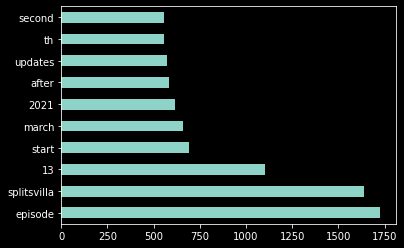

In [36]:
# convert training data to dataframe

X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words

X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [37]:
# Let's look at sklearn's stopwords.

print(CountVectorizer(stop_words = 'english').get_stop_words())

frozenset({'together', 'either', 'con', 'how', 'only', 'or', 'me', 'been', 'very', 'but', 'cant', 'call', 'fire', 'if', 'has', 'via', 'his', 'each', 'side', 'behind', 'every', 'that', 'nobody', 'several', 'co', 'couldnt', 'something', 'sincere', 'might', 'was', 'eleven', 'my', 'per', 'throughout', 'there', 'move', 'few', 'the', 'he', 'one', 'please', 'became', 'mill', 'detail', 'all', 'about', 'get', 'two', 'this', 'also', 'am', 'are', 'on', 'must', 'over', 'myself', 'everyone', 'full', 'four', 'we', 'no', 'next', 'cannot', 'besides', 'give', 'him', 'too', 'among', 'beforehand', 'bill', 'many', 'because', 'empty', 'much', 'ltd', 'upon', 'whenever', 'they', 'otherwise', 'system', 'hundred', 'alone', 'from', 'never', 'go', 'thereupon', 'do', 'part', 'at', 'an', 'therefore', 'against', 'name', 'then', 'it', 'out', 'amoungst', 'which', 'noone', 'their', 'were', 'hereafter', 'latterly', 'whether', 'whence', 'herein', 'etc', 'once', 'across', 'done', 'other', 'beside', 'cry', 'than', 'until'

In [38]:
# Redefine training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [39]:
y_test.value_counts(normalize=True)

NewsOfTheStupid    0.5
NewsOfTheWeird     0.5
Name: subreddit, dtype: float64

# GridSearchCV
---

At this point, I used my `pipeline` object as a model and:


1. Estimated how my model will perform on unseen data
2. Fitted my model
3. Got training score
4. Got test score


Since I wanted to tune over the `CountVectorizer`, I loaded my `pipeline` object into `GridSearchCV`.

In [40]:
X_train.head()

89     ['Splitsvilla', 'X3', '13th', 'March', '2021',...
529    ['Black', 'Mom', 'Sues', 'School', 'After', 'S...
920    ['Selling', 'image', 'my', 'foot', ',', 'hope'...
557    ['Splitsvilla', 'X3', '13th', 'March', '2021',...
658    ['Splitsvilla', 'X3', '13th', 'March', '2021',...
Name: title, dtype: object

In [41]:
X_train.value_counts()

['Splitsvilla', 'X3', '13th', 'March', '2021', 'Episode', 'full', 'Episode', ':', 'Fights', ',', 'Gold', 'Villa', 'Couples', 'Splitsvilla', '13', ',', 'Ideal', 'Match', 'Updates', 'MTV', 'Splitsvilla', '13', 'returns', 'its', 'second', 'episode', 'weekend', '.', 'After', 'glamour', '-filled', 'start', 'th', '...']    545
['(1)', 'New', 'Message', '-', 'Start', 'Living', 'The', 'Life', 'You', '‚Äôre', 'Dreaming', 'Of', '...']                                                                                                                                                                                                                      144
['[]']                                                                                                                                                                                                                                                                                                                          62
['Pinjara', 'Khubsurti', 'Ka', 

In [42]:
cv = CountVectorizer()

In [43]:
cv.fit(X_train)

CountVectorizer()

In [44]:
X_train_cv = cv.transform(X_train)

In [55]:
X_test_cv = cv.transform(X_test)

In [56]:
nb = MultinomialNB()

In [57]:
nb.fit(X_train_cv, y_train)

MultinomialNB()

# Scores

In [58]:
nb.score(X_train_cv, y_train)

0.7388059701492538

In [59]:
nb.score(X_test_cv, y_test)

0.740909090909091

# Accuracy Score

In [50]:
y_pred = nb.predict(X_test_cv)

In [51]:
acc_score = accuracy_score(y_test, y_pred)
print(acc_score)

0.740909090909091


# Confusion Matrix

In [52]:
cm = confusion_matrix(y_test, y_pred, labels=nb.classes_)
print(cm)

[[300  30]
 [141 189]]


<Figure size 1080x1080 with 0 Axes>

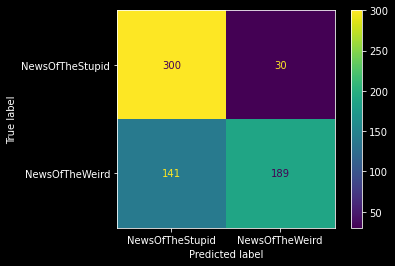

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
plt.figure(figsize=(15,15));
disp.plot();

# Classification report

In [60]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

NewsOfTheStupid       0.68      0.91      0.78       330
 NewsOfTheWeird       0.86      0.57      0.69       330

       accuracy                           0.74       660
      macro avg       0.77      0.74      0.73       660
   weighted avg       0.77      0.74      0.73       660

